In [1]:
import sys
sys.path.append("../src")

In [2]:
import os

import h5py
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from population_analysis.consts import TOTAL_TRIAL_MS, PRE_TRIAL_MS, POST_TRIAL_MS
from population_analysis.population.units import UnitPopulation
from population_analysis.consts import TOTAL_TRIAL_MS, SPIKE_BIN_MS, NUM_FIRINGRATE_SAMPLES

In [3]:
def _extract_timestamp_idxs(spike_timestamps, other_timestamps) -> list[[float, float, float]]:
    # return indices into spike_timestamps within a window of -200ms to +700ms for trials times in other_timestamps
    idx_ranges = []

    other_len = len(other_timestamps)
    other_one_tenth = int(1/10 * other_len)
    for idx, ts in enumerate(other_timestamps):
        if idx % other_one_tenth == 0:
            print(f" {round(100*(idx / other_len), 3)}%", end="")
        if np.isnan(ts):
            # idx_ranges.append(None)
            continue
        start_idx = np.where(ts - (PRE_TRIAL_MS/1000) < spike_timestamps)[0][0]  # First index in tuple, first index is the edge
        end_idx = np.where(ts + (POST_TRIAL_MS/1000) <= spike_timestamps)[0][0]
        ts_idx = np.where(ts >= spike_timestamps)[0][-1]  # Index of the event timestamp itself, next smallest value
        idx_ranges.append([start_idx, ts_idx, end_idx])
    print("")
    return idx_ranges


def _remove_by_idxs(lst: list, idxs: list[int]) -> list:
    # Filter out a list by indexes to not include
    l2 = []
    for idx, l in enumerate(lst):
        if idx in idxs:
            continue
        else:
            l2.append(l)
    return l2


def _demix_trials(saccade_idxs: list[list[float]], probe_idxs: list[list[float]]):
    # If a saccade and probe trial occur within +- .5 sec (500ms) then they should be considered a mixed trial
    trials = {
        "saccade": [],
        "probe": [],
        "mixed": []
    }

    # Find probes that occur within 500ms of a saccade, remove them from the list of possible
    # saccades/probes after finding them
    def within_window(list1, list2, label1, label2):  # Find events within eachothers bounds
        mixed = []
        l1_to_remove = []
        l2_to_remove = []

        for f_idx, first_idx in enumerate(list1):
            f_start = first_idx[0]  # first start
            f_end = first_idx[2]

            for s_idx, second_idx in enumerate(list2):
                s_event = second_idx[1]  # second event time idx
                if f_start <= s_event <= f_end:  # Found mixed
                    mixed.append({
                        label1: first_idx,
                        label2: second_idx
                    })
                    l2_to_remove.append(s_idx)
                    l1_to_remove.append(f_idx)
                    break
            list2 = _remove_by_idxs(list2, l2_to_remove)
            l2_to_remove = []
        list1 = _remove_by_idxs(list1, l1_to_remove)
        return [list1, list2, mixed]

    # Find saccades that occur within 500ms of a probe
    print("Demixing saccades within 500ms from a probe")
    saccade_idxs, probe_idxs, both = within_window(saccade_idxs, probe_idxs, "saccade", "probe")

    # Find probes that occur within 500ms of a saccade
    print("Demixing probes within 500ms of a saccade")
    probe_idxs, saccade_idxs, both2 = within_window(probe_idxs, saccade_idxs, "probe", "saccade")

    trials["saccade"] = saccade_idxs
    trials["probe"] = probe_idxs
    trials["mixed"] = [*both, *both2]

    return trials



In [4]:
filename = 'E:\\PopulationAnalysis\\2023-05-16\\mlati7\\output.hdf'

In [5]:
data = h5py.File(filename)
spike_clusters = np.array(data["spikes"]["clusters"])
spike_timestamps = np.array(data["spikes"]["timestamps"])
probe_timestamps = np.array(data["stimuli"]["dg"]["probe"]["timestamps"])
saccade_timestamps = np.array(data["saccades"]["predicted"]["left"]["nasal"]["timestamps"])

In [133]:
idxs = np.where(spike_clusters == 5)
spike_timestamps[idxs][0]

0.853

In [44]:
unit_pop = UnitPopulation(spike_timestamps, spike_clusters)

print("Extracting saccade spike timestamps..")
saccade_spike_range_idxs = _extract_timestamp_idxs(spike_timestamps, saccade_timestamps)
print("Extracting probe spike timestamps..")
probe_spike_range_idxs = _extract_timestamp_idxs(spike_timestamps, probe_timestamps)



Extracting saccade spike timestamps..
 0.0% 9.962% 19.924% 29.886% 39.848% 49.81% 59.772% 69.734% 79.696% 89.658% 99.62%
Extracting probe spike timestamps..
 0.0% 9.995% 19.991% 29.986% 39.981% 49.977% 59.972% 69.967% 79.963% 89.958% 99.953%


In [45]:
trials = _demix_trials(saccade_spike_range_idxs, probe_spike_range_idxs)

unit_pop.add_probe_trials(trials["probe"])
unit_pop.add_saccade_trials(trials["saccade"])
unit_pop.add_mixed_trials(trials["mixed"])

Demixing saccades within 500ms from a probe
Demixing probes within 500ms of a saccade


In [46]:
# Calculate the firing rate of each unit for all trials
self = unit_pop

firing_rates = np.zeros((len(self._trials), self.num_units, NUM_FIRINGRATE_SAMPLES))
        
#for trial_idx, trial in enumerate(self._trials):
trial_idx = 1
trial = self._trials[1]
print(f"Working on trial {trial_idx}")
trial_spike_times = self.spike_timestamps[trial.start:trial.end]
trial_start = self.spike_timestamps[trial.start]
# Make sure that the length of the trial is at least 700ms
trial_end = max(self.spike_timestamps[trial.end], trial_start + TOTAL_TRIAL_MS/1000)
trial_spike_clusters = self.spike_clusters[trial.start:trial.end]

unique_units = np.unique(trial_spike_clusters)

all_units_mask = np.broadcast_to(trial_spike_clusters[:, None].T,
                                 (len(unique_units), len(trial_spike_clusters)))
all_units_mask = all_units_mask == unique_units[:, None]  # Mask on trial for each unique value

unmasked_spike_times = np.broadcast_to(trial_spike_times, (len(unique_units), *trial_spike_times.shape))
# Mask out the times where the spike time doesn't belong to each spike
unique_unit_spike_times = ma.array(unmasked_spike_times, mask=~all_units_mask)

# Get the spike timings of unit 2, 'compressed' removed masked values
# unit_spike_times[2].compressed()

bins = np.arange(trial_start, trial_end + SPIKE_BIN_MS/1000, SPIKE_BIN_MS / 1000)
bins = bins[:NUM_FIRINGRATE_SAMPLES + 1]  # Ensure that there are only 35 bins



Working on trial 1


In [49]:
self.unique_spike_clusters = np.unique(self.spike_clusters)

In [57]:
idx = 88
v = np.where(self.unique_spike_clusters == unique_units[idx])

In [58]:
unique_units[idx], self.unique_spike_clusters[]

(467, 467)

In [ ]:
unit_spike_times.shape, self.num_units, self.unique_spike_clusters.shape

In [82]:
print(f"Calculating firing rates for all units in trial {trial_idx}", end="")
num_unique_units = len(unique_units)
one_tenth_of_units = int(num_unique_units / 10)
abs_unit_idxs = []
for unique_unit_num in range(num_unique_units):
    if unique_unit_num % one_tenth_of_units == 0:
        print(f" {round(100*(unique_unit_num / num_unique_units), 2)}%", end="")
    single_unit_spike_times = unique_unit_spike_times[unique_unit_num]
    #print(f"\n{single_unit_spike_times}")
    single_unit_spike_times = single_unit_spike_times.compressed()
    single_unit_firing_rate = np.histogram(
        single_unit_spike_times, bins=bins, density=False
    )[0]/SPIKE_BIN_MS  # Normalize by bin size
   # print("")
   # print(f"Bins {len(bins)} Compr {len(unit_spike_times[unit_num].compressed())}")
   # print(f"{single_unit_firing_rate.shape}")
    absolute_unit_idx = np.where(self.unique_spike_clusters == unique_units[unique_unit_num])[0][0]
    abs_unit_idxs.append(absolute_unit_idx)
    firing_rates[trial_idx, absolute_unit_idx, :] = single_unit_firing_rate[:]
print("")

Calculating firing rates for all units in trial 1 0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0%


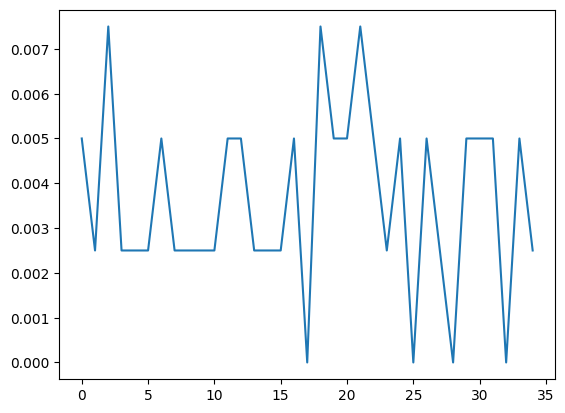

In [100]:
plt.plot(firing_rates[1, 9]/SPIKE_BIN_MS)

In [101]:
self.trials[0]

AttributeError: 'UnitPopulation' object has no attribute 'trials'

In [107]:
trial_labels = [trial.trial_label for trial in self._trials]

In [118]:
mixed_idxs = np.where(np.array(trial_labels) == "probe")[0]

In [119]:
mixed_idxs[0]

0

In [115]:
tr = self._trials[mixed_idxs[0]]

In [117]:
tr.events

{'saccade_start': 1857363,
 'saccade_event': 1857466,
 'saccade_end': 1857731,
 'probe_start': 1857419,
 'probe_event': 1857524,
 'probe_end': 1857847}